# Hyperparameter tuning

To improve the performance of our model, we need to delve into the realm of hyperparameter tuning. Hyperparameters are settings that we can adjust to optimize the behavior and accuracy of our machine learning model, to fine-tune it's performance. 

The previous model was trained with certain default hyperparameter values, which serve as a baseline. However, these default values may not always yield the best results for our specific problem.

Hyperparameter tuning involves systematically exploring different combinations of hyperparameter values to find the optimal configuration that maximizes our model's performance. This process is often iterative and involves training and evaluating the model multiple times with different hyperparameter settings.

In [2]:
import sys
sys.path.insert(0, './src')
import utils



import albumentations as A
import os
import torch
import torch.nn as nn
import warnings
import torch.utils.data as data
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning) # Masks are not georeferences, so we can ignore this warning
warnings.filterwarnings("ignore", category=UserWarning) # This will throw a warning message about cudnn, this is normal (https://github.com/pytorch/pytorch/pull/125790)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [4]:
# MEAN = [63.02235933, 66.64201154, 60.63862196]
# STD = [55.50368184, 55.35826425, 52.63471437]
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
MAX_LR = 1e-4
TRAIN_SIZE = 320
VAL_SIZE = 360
NUM_WORKERS = 4
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 4
EPOCHS = 80
LOAD_BEST = True
NAME = "6 - LR1e-4 TrainBatch8 Epoch80 Resize - NoAugmentation"

DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
DATA_PATH = OUTPUT_PATH + "data/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"

We'll reimport the default values that we had from before

We slightly modified the values of the transformations! We're having a better alignment, and using A.RandomCrop is better than A.Resize because you don't loose details

Using PyTorch version: 2.3.0+cu121  Device: cuda
PyTorch version:  2.3.0+cu121
CUDA version:  12.1
cuDNN version:  8902
Image shape: torch.Size([8, 3, 320, 320]), Mask shape: torch.Size([8, 1, 320, 320])


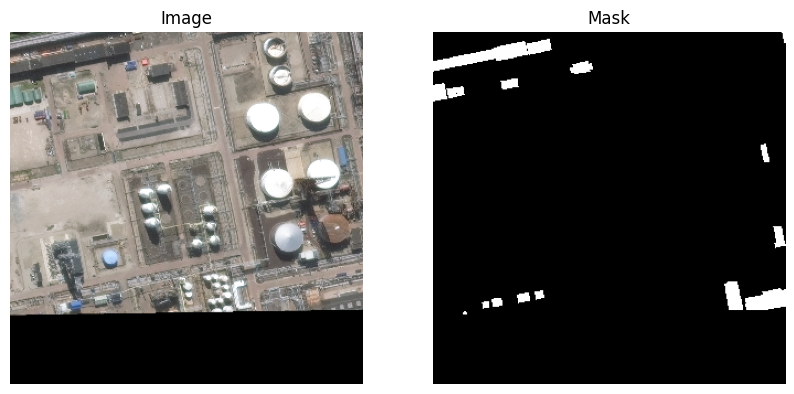

In [5]:
device = utils.set_cuda_and_seed()

print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())


train_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.CenterCrop(896, 896),
    A.Resize(TRAIN_SIZE, TRAIN_SIZE),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5)
])

eval_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.CenterCrop(896, 896),
    A.Resize(VAL_SIZE, VAL_SIZE)
])
from dataset import SN6Dataset

train_dataset = SN6Dataset(DATASET_PATH, transform=train_transforms, split='train')
eval_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='val')
test_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='test')

train_loader = data.DataLoader(train_dataset, pin_memory = True, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
eval_loader = data.DataLoader(eval_dataset, pin_memory = True, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = data.DataLoader(test_dataset, pin_memory = True, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

image, mask = next(iter(train_loader))
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
utils.visualize_image(image[0], mask[0])

We'll be trying something new: A custom loss function that connects both BCEWithLogitLoss and a custom-made Dice loss (since we already established it's our best parameter) in a 50/50 mix. It's been implemented in _custom_loss.py_

we'll try to work on 
 - Normalization
 - A better Segmentation
 - Maybe slowing down the learning rate even further
 

In [6]:
from model import UNET

model = UNET(in_channels = 3, out_channels = 1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=MAX_LR, weight_decay=1e-5)

# We won't use a scheduler at first, but we'll add it later
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS)
scaler = torch.cuda.amp.GradScaler()


One of the things I've noticed in the training is how hard it's for the model to track small buildings, this is because to make our batch_size higher a downscale was necessary; we modified some values, changing:
 - SIZE to 300x300
 - BATCH_SIZE to 8

In [5]:
from train import train

best_f1 = 0.0
history = {
    'train_loss': [],
    'val_loss': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': [],
    'last_epoch': 0 
}

last_epoch = 0
if LOAD_BEST:
    print("Restoring best model")
    if(os.path.exists(CHECKPOINT_PATH + f"best_{NAME}.pth")):
        history = utils.load_checkpoint(CHECKPOINT_PATH + f"best_{NAME}.pth", model, optimizer, scheduler)
        best_f1 = max(history['f1'])
        last_epoch = history['last_epoch']
        print(f"Best model found, starting from epoch {last_epoch+1} with f1_score {best_f1}")
    else:
        print("Best model not found, starting from scratch")

# Training model
for epoch in range(last_epoch, EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_loss = train(train_loader, model, optimizer, criterion, scaler, scheduler, device)
    # Detect if loss is NaN, and immediately stop with a ValueError 
    
    
    eval_loss, precision, recall, f1, accuracy = utils.get_evals(eval_loader, model, criterion, device, save_predictions=True, output_path=DATA_PATH)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(eval_loss)
    history['precision'].append(precision)
    history['recall'].append(recall)
    history['f1'].append(f1)
    history['accuracy'].append(accuracy)
    history['last_epoch'] = epoch
    print(f"Train loss: {train_loss:.4f} Eval loss: {eval_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f} Accuracy: {accuracy:.4f}")
    # Save model
    checkpoint = {
        "history" : history,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": criterion.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + f"checkpoint_{NAME}.pth")
    if f1 > best_f1:
        best_f1 = f1
        utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + f"best_{NAME}.pth")
        print("Best model saved")

    if epoch - 5 > 0: # Value of validation loss is increasing, model is overfitting. Need to stop training
        if history['val_loss'][epoch] > history['val_loss'][epoch-1] > history['val_loss'][epoch-2] > history['val_loss'][epoch-3] > history['val_loss'][epoch-4]:
            print("Early stopping")
            break
print("Finished training! Well done :3\nQuitting...")

Restoring best model
Best model not found, starting from scratch
Epoch 1 of 100


Loss: 0.4970: 100%|██████████| 340/340 [01:44<00:00,  3.25it/s]

Saving predictions to: output/data/


Train loss: 0.6000 Eval loss: 0.4908 Precision: 0.3007 Recall: 0.5566 F1: 0.3905 Accuracy: 0.8819
saving checkpoint
saving checkpoint
Best model saved
Epoch 2 of 100


Loss: 0.3896: 100%|██████████| 340/340 [01:43<00:00,  3.27it/s]

Saving predictions to: output/data/


Train loss: 0.4428 Eval loss: 0.4081 Precision: 0.4957 Recall: 0.4656 F1: 0.4802 Accuracy: 0.9315
saving checkpoint
saving checkpoint
Best model saved
Epoch 3 of 100


Loss: 0.3714: 100%|██████████| 340/340 [01:45<00:00,  3.24it/s]

Saving predictions to: output/data/


Train loss: 0.3858 Eval loss: 0.3517 Precision: 0.5840 Recall: 0.5430 F1: 0.5628 Accuracy: 0.9427
saving checkpoint
saving checkpoint
Best model saved
Epoch 4 of 100


Loss: 0.3438: 100%|██████████| 340/340 [01:54<00:00,  2.98it/s]

Saving predictions to: output/data/


Train loss: 0.3598 Eval loss: 0.3303 Precision: 0.5989 Recall: 0.5983 F1: 0.5986 Accuracy: 0.9455
saving checkpoint
saving checkpoint
Best model saved
Epoch 5 of 100


Loss: 0.3469: 100%|██████████| 340/340 [01:45<00:00,  3.22it/s]

Saving predictions to: output/data/


Train loss: 0.3402 Eval loss: 0.3206 Precision: 0.5539 Recall: 0.6870 F1: 0.6133 Accuracy: 0.9411
saving checkpoint
saving checkpoint
Best model saved
Epoch 6 of 100


Loss: 0.2987: 100%|██████████| 340/340 [01:45<00:00,  3.22it/s]

Saving predictions to: output/data/


Train loss: 0.3231 Eval loss: 0.2973 Precision: 0.6516 Recall: 0.5986 F1: 0.6239 Accuracy: 0.9510
saving checkpoint
saving checkpoint
Best model saved
Epoch 7 of 100


Loss: 0.3122: 100%|██████████| 340/340 [01:42<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.3012 Eval loss: 0.2927 Precision: 0.5041 Recall: 0.7897 F1: 0.6153 Accuracy: 0.9329
saving checkpoint
Epoch 8 of 100


Loss: 0.2599: 100%|██████████| 340/340 [01:44<00:00,  3.24it/s]

Saving predictions to: output/data/


Train loss: 0.2811 Eval loss: 0.2540 Precision: 0.6514 Recall: 0.6785 F1: 0.6646 Accuracy: 0.9535
saving checkpoint
saving checkpoint
Best model saved
Epoch 9 of 100


Loss: 0.2453: 100%|██████████| 340/340 [01:43<00:00,  3.28it/s]

Saving predictions to: output/data/


Train loss: 0.2575 Eval loss: 0.2374 Precision: 0.7013 Recall: 0.6336 F1: 0.6657 Accuracy: 0.9568
saving checkpoint
saving checkpoint
Best model saved
Epoch 10 of 100


Loss: 0.2213: 100%|██████████| 340/340 [01:43<00:00,  3.29it/s]

Saving predictions to: output/data/


Train loss: 0.2339 Eval loss: 0.2103 Precision: 0.8241 Recall: 0.4839 F1: 0.6098 Accuracy: 0.9579
saving checkpoint
Epoch 11 of 100


Loss: 0.1837: 100%|██████████| 340/340 [01:43<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.2079 Eval loss: 0.1955 Precision: 0.6857 Recall: 0.6983 F1: 0.6919 Accuracy: 0.9577
saving checkpoint
saving checkpoint
Best model saved
Epoch 12 of 100


Loss: 0.1852: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.1856 Eval loss: 0.1628 Precision: 0.7546 Recall: 0.6970 F1: 0.7247 Accuracy: 0.9640
saving checkpoint
saving checkpoint
Best model saved
Epoch 13 of 100


Loss: 0.1442: 100%|██████████| 340/340 [01:43<00:00,  3.28it/s]

Saving predictions to: output/data/


Train loss: 0.1658 Eval loss: 0.1465 Precision: 0.8839 Recall: 0.5096 F1: 0.6465 Accuracy: 0.9621
saving checkpoint
Epoch 14 of 100


Loss: 0.1372: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.1447 Eval loss: 0.1349 Precision: 0.8143 Recall: 0.6458 F1: 0.7204 Accuracy: 0.9659
saving checkpoint
Epoch 15 of 100


Loss: 0.1572: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.1320 Eval loss: 0.1287 Precision: 0.8938 Recall: 0.4565 F1: 0.6043 Accuracy: 0.9594
saving checkpoint
Epoch 16 of 100


Loss: 0.0918: 100%|██████████| 340/340 [01:44<00:00,  3.26it/s]

Saving predictions to: output/data/


Train loss: 0.1177 Eval loss: 0.1056 Precision: 0.8500 Recall: 0.6660 F1: 0.7468 Accuracy: 0.9693
saving checkpoint
saving checkpoint
Best model saved
Epoch 17 of 100


Loss: 0.0961: 100%|██████████| 340/340 [01:43<00:00,  3.29it/s]

Saving predictions to: output/data/


Train loss: 0.1065 Eval loss: 0.0991 Precision: 0.7620 Recall: 0.7581 F1: 0.7601 Accuracy: 0.9675
saving checkpoint
saving checkpoint
Best model saved
Epoch 18 of 100


Loss: 0.0752: 100%|██████████| 340/340 [01:43<00:00,  3.29it/s]

Saving predictions to: output/data/


Train loss: 0.1006 Eval loss: 0.0867 Precision: 0.8230 Recall: 0.7370 F1: 0.7776 Accuracy: 0.9714
saving checkpoint
saving checkpoint
Best model saved
Epoch 19 of 100


Loss: 0.1228: 100%|██████████| 340/340 [01:43<00:00,  3.29it/s]

Saving predictions to: output/data/


Train loss: 0.0905 Eval loss: 0.0824 Precision: 0.8787 Recall: 0.6660 F1: 0.7577 Accuracy: 0.9711
saving checkpoint
Epoch 20 of 100


Loss: 0.1025: 100%|██████████| 340/340 [01:43<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.0850 Eval loss: 0.0881 Precision: 0.8671 Recall: 0.6260 F1: 0.7271 Accuracy: 0.9681
saving checkpoint
Epoch 21 of 100


Loss: 0.0879: 100%|██████████| 340/340 [01:42<00:00,  3.32it/s]

Saving predictions to: output/data/


Train loss: 0.0802 Eval loss: 0.0953 Precision: 0.7657 Recall: 0.6718 F1: 0.7157 Accuracy: 0.9637
saving checkpoint
Epoch 22 of 100


Loss: 0.1068: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0793 Eval loss: 0.0722 Precision: 0.8463 Recall: 0.7301 F1: 0.7839 Accuracy: 0.9726
saving checkpoint
saving checkpoint
Best model saved
Epoch 23 of 100


Loss: 0.0568: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0728 Eval loss: 0.0635 Precision: 0.8796 Recall: 0.7437 F1: 0.8060 Accuracy: 0.9757
saving checkpoint
saving checkpoint
Best model saved
Epoch 24 of 100


Loss: 0.0845: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0729 Eval loss: 0.0747 Precision: 0.8560 Recall: 0.6804 F1: 0.7582 Accuracy: 0.9705
saving checkpoint
Epoch 25 of 100


Loss: 0.0395: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0685 Eval loss: 0.0773 Precision: 0.8973 Recall: 0.6192 F1: 0.7328 Accuracy: 0.9693
saving checkpoint
Epoch 26 of 100


Loss: 0.1041: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0672 Eval loss: 0.0600 Precision: 0.8404 Recall: 0.8054 F1: 0.8225 Accuracy: 0.9764
saving checkpoint
saving checkpoint
Best model saved
Epoch 27 of 100


Loss: 0.0684: 100%|██████████| 340/340 [01:47<00:00,  3.17it/s]

Saving predictions to: output/data/


Train loss: 0.0647 Eval loss: 0.0619 Precision: 0.8879 Recall: 0.7340 F1: 0.8037 Accuracy: 0.9756
saving checkpoint
Epoch 28 of 100


Loss: 0.0788: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0610 Eval loss: 0.0668 Precision: 0.8906 Recall: 0.6967 F1: 0.7818 Accuracy: 0.9736
saving checkpoint
Epoch 29 of 100


Loss: 0.0549: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0617 Eval loss: 0.0561 Precision: 0.8723 Recall: 0.7874 F1: 0.8277 Accuracy: 0.9777
saving checkpoint
saving checkpoint
Best model saved
Epoch 30 of 100


Loss: 0.0620: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0577 Eval loss: 0.0616 Precision: 0.8356 Recall: 0.7968 F1: 0.8157 Accuracy: 0.9755
saving checkpoint
Epoch 31 of 100


Loss: 0.0855: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0631 Eval loss: 0.0557 Precision: 0.8754 Recall: 0.7838 F1: 0.8271 Accuracy: 0.9777
saving checkpoint
Epoch 32 of 100


Loss: 0.0212: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0556 Eval loss: 0.0524 Precision: 0.8719 Recall: 0.8087 F1: 0.8391 Accuracy: 0.9789
saving checkpoint
saving checkpoint
Best model saved
Epoch 33 of 100


Loss: 0.0363: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0571 Eval loss: 0.0495 Precision: 0.8935 Recall: 0.8015 F1: 0.8450 Accuracy: 0.9800
saving checkpoint
saving checkpoint
Best model saved
Epoch 34 of 100


Loss: 0.0259: 100%|██████████| 340/340 [01:41<00:00,  3.37it/s]

Saving predictions to: output/data/


Train loss: 0.0555 Eval loss: 0.0511 Precision: 0.8773 Recall: 0.8129 F1: 0.8439 Accuracy: 0.9796
saving checkpoint
Epoch 35 of 100


Loss: 0.0641: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0533 Eval loss: 0.0523 Precision: 0.8747 Recall: 0.8015 F1: 0.8365 Accuracy: 0.9787
saving checkpoint
Epoch 36 of 100


Loss: 0.0323: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0506 Eval loss: 0.0632 Precision: 0.8846 Recall: 0.7357 F1: 0.8033 Accuracy: 0.9755
saving checkpoint
Epoch 37 of 100


Loss: 0.0391: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0494 Eval loss: 0.0472 Precision: 0.9026 Recall: 0.8065 F1: 0.8519 Accuracy: 0.9809
saving checkpoint
saving checkpoint
Best model saved
Epoch 38 of 100


Loss: 0.0269: 100%|██████████| 340/340 [01:46<00:00,  3.20it/s]

Saving predictions to: output/data/


Train loss: 0.0498 Eval loss: 0.0475 Precision: 0.8746 Recall: 0.8367 F1: 0.8552 Accuracy: 0.9807
saving checkpoint
saving checkpoint
Best model saved
Epoch 39 of 100


Loss: 0.0508: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0495 Eval loss: 0.0453 Precision: 0.8965 Recall: 0.8261 F1: 0.8599 Accuracy: 0.9817
saving checkpoint
saving checkpoint
Best model saved
Epoch 40 of 100


Loss: 0.0471: 100%|██████████| 340/340 [01:43<00:00,  3.28it/s]

Saving predictions to: output/data/


Train loss: 0.0472 Eval loss: 0.0435 Precision: 0.8965 Recall: 0.8346 F1: 0.8645 Accuracy: 0.9822
saving checkpoint
saving checkpoint
Best model saved
Epoch 41 of 100


Loss: 0.0370: 100%|██████████| 340/340 [01:43<00:00,  3.29it/s]

Saving predictions to: output/data/


Train loss: 0.0462 Eval loss: 0.0543 Precision: 0.8720 Recall: 0.8003 F1: 0.8346 Accuracy: 0.9784
saving checkpoint
Epoch 42 of 100


Loss: 0.0385: 100%|██████████| 340/340 [01:43<00:00,  3.28it/s]

Saving predictions to: output/data/


Train loss: 0.0462 Eval loss: 0.0460 Precision: 0.8836 Recall: 0.8329 F1: 0.8575 Accuracy: 0.9812
saving checkpoint
Epoch 43 of 100


Loss: 0.0736: 100%|██████████| 340/340 [01:43<00:00,  3.29it/s]

Saving predictions to: output/data/


Train loss: 0.0472 Eval loss: 0.0623 Precision: 0.8449 Recall: 0.7885 F1: 0.8157 Accuracy: 0.9758
saving checkpoint
Epoch 44 of 100


Loss: 0.0563: 100%|██████████| 340/340 [01:42<00:00,  3.31it/s]

Saving predictions to: output/data/


Train loss: 0.0473 Eval loss: 0.0446 Precision: 0.9216 Recall: 0.8060 F1: 0.8599 Accuracy: 0.9822
saving checkpoint
Epoch 45 of 100


Loss: 0.0392: 100%|██████████| 340/340 [01:46<00:00,  3.18it/s]

Saving predictions to: output/data/


Train loss: 0.0424 Eval loss: 0.0411 Precision: 0.8930 Recall: 0.8540 F1: 0.8730 Accuracy: 0.9831
saving checkpoint
saving checkpoint
Best model saved
Epoch 46 of 100


Loss: 0.0286: 100%|██████████| 340/340 [01:43<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.0427 Eval loss: 0.0417 Precision: 0.9115 Recall: 0.8323 F1: 0.8701 Accuracy: 0.9831
saving checkpoint
Epoch 47 of 100


Loss: 0.0381: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0488 Eval loss: 0.0404 Precision: 0.9067 Recall: 0.8430 F1: 0.8737 Accuracy: 0.9834
saving checkpoint
saving checkpoint
Best model saved
Epoch 48 of 100


Loss: 0.0370: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0416 Eval loss: 0.0444 Precision: 0.8955 Recall: 0.8397 F1: 0.8667 Accuracy: 0.9824
saving checkpoint
Epoch 49 of 100


Loss: 0.0374: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0399 Eval loss: 0.0416 Precision: 0.9121 Recall: 0.8362 F1: 0.8725 Accuracy: 0.9834
saving checkpoint
Epoch 50 of 100


Loss: 0.0207: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0389 Eval loss: 0.0384 Precision: 0.9013 Recall: 0.8626 F1: 0.8816 Accuracy: 0.9842
saving checkpoint
saving checkpoint
Best model saved
Epoch 51 of 100


Loss: 0.0441: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0417 Eval loss: 0.0386 Precision: 0.9039 Recall: 0.8599 F1: 0.8813 Accuracy: 0.9843
saving checkpoint
Epoch 52 of 100


Loss: 0.0854: 100%|██████████| 340/340 [01:49<00:00,  3.09it/s]

Saving predictions to: output/data/


Train loss: 0.0385 Eval loss: 0.0367 Precision: 0.9014 Recall: 0.8717 F1: 0.8863 Accuracy: 0.9848
saving checkpoint
saving checkpoint
Best model saved
Epoch 53 of 100


Loss: 0.0216: 100%|██████████| 340/340 [01:42<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.0377 Eval loss: 0.0371 Precision: 0.9061 Recall: 0.8642 F1: 0.8847 Accuracy: 0.9847
saving checkpoint
Epoch 54 of 100


Loss: 0.0196: 100%|██████████| 340/340 [01:42<00:00,  3.32it/s]

Saving predictions to: output/data/


Train loss: 0.0369 Eval loss: 0.0365 Precision: 0.9165 Recall: 0.8559 F1: 0.8852 Accuracy: 0.9849
saving checkpoint
Epoch 55 of 100


Loss: 0.0429: 100%|██████████| 340/340 [01:43<00:00,  3.29it/s]

Saving predictions to: output/data/


Train loss: 0.0366 Eval loss: 0.0360 Precision: 0.9142 Recall: 0.8641 F1: 0.8885 Accuracy: 0.9853
saving checkpoint
saving checkpoint
Best model saved
Epoch 56 of 100


Loss: 0.0509: 100%|██████████| 340/340 [01:43<00:00,  3.28it/s]

Saving predictions to: output/data/


Train loss: 0.0378 Eval loss: 0.0369 Precision: 0.9130 Recall: 0.8628 F1: 0.8872 Accuracy: 0.9851
saving checkpoint
Epoch 57 of 100


Loss: 0.0193: 100%|██████████| 340/340 [01:44<00:00,  3.25it/s]

Saving predictions to: output/data/


Train loss: 0.0357 Eval loss: 0.0388 Precision: 0.9057 Recall: 0.8565 F1: 0.8804 Accuracy: 0.9842
saving checkpoint
Epoch 58 of 100


Loss: 0.0407: 100%|██████████| 340/340 [01:44<00:00,  3.24it/s]

Saving predictions to: output/data/


Train loss: 0.0359 Eval loss: 0.0358 Precision: 0.9216 Recall: 0.8587 F1: 0.8890 Accuracy: 0.9854
saving checkpoint
saving checkpoint
Best model saved
Epoch 59 of 100


Loss: 0.0461: 100%|██████████| 340/340 [01:44<00:00,  3.26it/s]

Saving predictions to: output/data/


Train loss: 0.0348 Eval loss: 0.0351 Precision: 0.9263 Recall: 0.8571 F1: 0.8904 Accuracy: 0.9857
saving checkpoint
saving checkpoint
Best model saved
Epoch 60 of 100


Loss: 0.0279: 100%|██████████| 340/340 [01:45<00:00,  3.22it/s]

Saving predictions to: output/data/


Train loss: 0.0344 Eval loss: 0.0340 Precision: 0.9141 Recall: 0.8769 F1: 0.8951 Accuracy: 0.9860
saving checkpoint
saving checkpoint
Best model saved
Epoch 61 of 100


Loss: 0.0191: 100%|██████████| 340/340 [01:43<00:00,  3.28it/s]

Saving predictions to: output/data/


Train loss: 0.0339 Eval loss: 0.0336 Precision: 0.9184 Recall: 0.8723 F1: 0.8947 Accuracy: 0.9861
saving checkpoint
Epoch 62 of 100


Loss: 0.0240: 100%|██████████| 340/340 [01:44<00:00,  3.25it/s]

Saving predictions to: output/data/


Train loss: 0.0335 Eval loss: 0.0338 Precision: 0.9106 Recall: 0.8831 F1: 0.8966 Accuracy: 0.9862
saving checkpoint
saving checkpoint
Best model saved
Epoch 63 of 100


Loss: 0.0484: 100%|██████████| 340/340 [01:44<00:00,  3.24it/s]

Saving predictions to: output/data/


Train loss: 0.0326 Eval loss: 0.0338 Precision: 0.9098 Recall: 0.8826 F1: 0.8960 Accuracy: 0.9861
saving checkpoint
Epoch 64 of 100


Loss: 0.0213: 100%|██████████| 340/340 [01:51<00:00,  3.06it/s]

Saving predictions to: output/data/


Train loss: 0.0326 Eval loss: 0.0361 Precision: 0.9153 Recall: 0.8649 F1: 0.8894 Accuracy: 0.9854
saving checkpoint
Epoch 65 of 100


Loss: 0.0301: 100%|██████████| 340/340 [01:43<00:00,  3.29it/s]

Saving predictions to: output/data/


Train loss: 0.0326 Eval loss: 0.0340 Precision: 0.9258 Recall: 0.8651 F1: 0.8944 Accuracy: 0.9861
saving checkpoint
Epoch 66 of 100


Loss: 0.0150: 100%|██████████| 340/340 [01:43<00:00,  3.28it/s]

Saving predictions to: output/data/


Train loss: 0.0310 Eval loss: 0.0333 Precision: 0.9248 Recall: 0.8715 F1: 0.8974 Accuracy: 0.9865
saving checkpoint
saving checkpoint
Best model saved
Epoch 67 of 100


Loss: 0.0356: 100%|██████████| 340/340 [01:43<00:00,  3.27it/s]

Saving predictions to: output/data/


Train loss: 0.0308 Eval loss: 0.0323 Precision: 0.9217 Recall: 0.8794 F1: 0.9001 Accuracy: 0.9867
saving checkpoint
saving checkpoint
Best model saved
Epoch 68 of 100


Loss: 0.0407: 100%|██████████| 340/340 [01:43<00:00,  3.29it/s]

Saving predictions to: output/data/


Train loss: 0.0307 Eval loss: 0.0317 Precision: 0.9250 Recall: 0.8788 F1: 0.9013 Accuracy: 0.9869
saving checkpoint
saving checkpoint
Best model saved
Epoch 69 of 100


Loss: 0.0286: 100%|██████████| 340/340 [01:42<00:00,  3.31it/s]

Saving predictions to: output/data/


Train loss: 0.0306 Eval loss: 0.0326 Precision: 0.9196 Recall: 0.8808 F1: 0.8998 Accuracy: 0.9867
saving checkpoint
Epoch 70 of 100


Loss: 0.0101: 100%|██████████| 340/340 [01:43<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.0298 Eval loss: 0.0312 Precision: 0.9212 Recall: 0.8871 F1: 0.9039 Accuracy: 0.9872
saving checkpoint
saving checkpoint
Best model saved
Epoch 71 of 100


Loss: 0.0347: 100%|██████████| 340/340 [01:43<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.0294 Eval loss: 0.0320 Precision: 0.9244 Recall: 0.8801 F1: 0.9017 Accuracy: 0.9870
saving checkpoint
Epoch 72 of 100


Loss: 0.0203: 100%|██████████| 340/340 [01:42<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.0291 Eval loss: 0.0320 Precision: 0.9217 Recall: 0.8831 F1: 0.9020 Accuracy: 0.9870
saving checkpoint
Epoch 73 of 100


Loss: 0.0351: 100%|██████████| 340/340 [01:43<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.0287 Eval loss: 0.0314 Precision: 0.9229 Recall: 0.8865 F1: 0.9043 Accuracy: 0.9873
saving checkpoint
saving checkpoint
Best model saved
Epoch 74 of 100


Loss: 0.0412: 100%|██████████| 340/340 [01:43<00:00,  3.28it/s]

Saving predictions to: output/data/


Train loss: 0.0283 Eval loss: 0.0317 Precision: 0.9267 Recall: 0.8799 F1: 0.9027 Accuracy: 0.9871
saving checkpoint
Epoch 75 of 100


Loss: 0.0273: 100%|██████████| 340/340 [01:42<00:00,  3.31it/s]

Saving predictions to: output/data/


Train loss: 0.0279 Eval loss: 0.0315 Precision: 0.9241 Recall: 0.8850 F1: 0.9041 Accuracy: 0.9872
saving checkpoint
Epoch 76 of 100


Loss: 0.0119: 100%|██████████| 340/340 [01:42<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.0279 Eval loss: 0.0302 Precision: 0.9225 Recall: 0.8929 F1: 0.9074 Accuracy: 0.9876
saving checkpoint
saving checkpoint
Best model saved
Epoch 77 of 100


Loss: 0.0304: 100%|██████████| 340/340 [01:45<00:00,  3.23it/s]

Saving predictions to: output/data/


Train loss: 0.0278 Eval loss: 0.0303 Precision: 0.9237 Recall: 0.8898 F1: 0.9064 Accuracy: 0.9875
saving checkpoint
Epoch 78 of 100


Loss: 0.0218: 100%|██████████| 340/340 [01:44<00:00,  3.25it/s]

Saving predictions to: output/data/


Train loss: 0.0271 Eval loss: 0.0308 Precision: 0.9259 Recall: 0.8875 F1: 0.9063 Accuracy: 0.9875
saving checkpoint
Epoch 79 of 100


Loss: 0.0321: 100%|██████████| 340/340 [01:46<00:00,  3.18it/s]

Saving predictions to: output/data/


Train loss: 0.0268 Eval loss: 0.0307 Precision: 0.9289 Recall: 0.8863 F1: 0.9071 Accuracy: 0.9877
saving checkpoint
Epoch 80 of 100


Loss: 0.0399: 100%|██████████| 340/340 [01:50<00:00,  3.08it/s]

Saving predictions to: output/data/


Train loss: 0.0266 Eval loss: 0.0303 Precision: 0.9301 Recall: 0.8866 F1: 0.9078 Accuracy: 0.9878
saving checkpoint
saving checkpoint
Best model saved
Epoch 81 of 100


Loss: 0.0299:  15%|█▌        | 51/340 [00:17<01:37,  2.95it/s]


KeyboardInterrupt: 

loading checkpoint


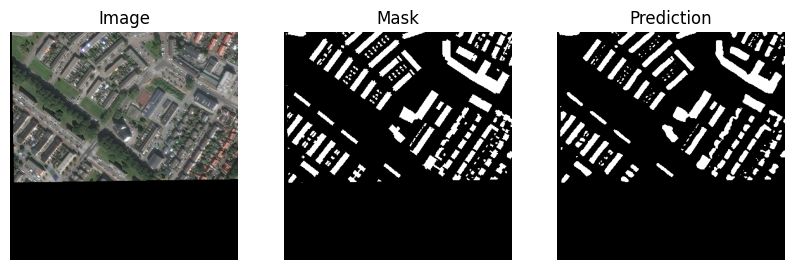

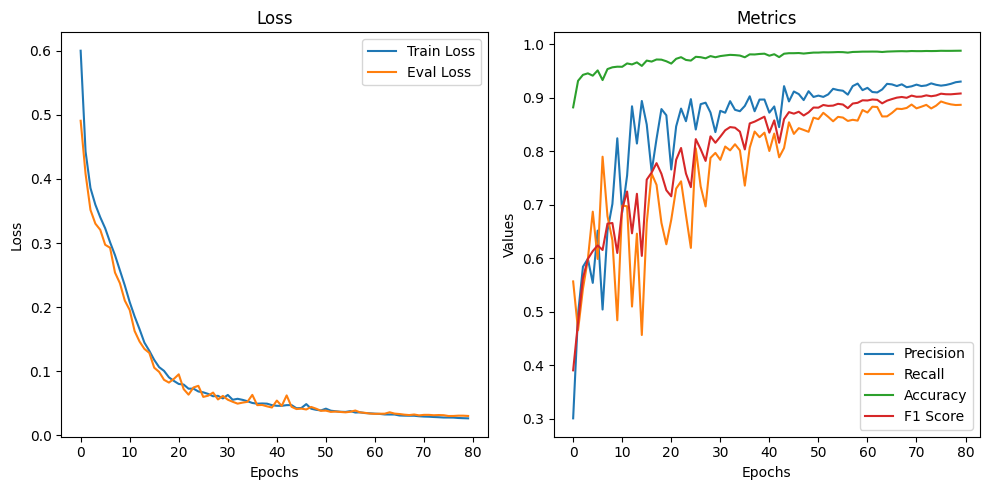

In [7]:
import matplotlib.pyplot as plt

# Get the history
history = utils.load_checkpoint(CHECKPOINT_PATH + f"checkpoint_{NAME}.pth", model)
image, mask, pred = utils.get_random_image(eval_loader, model, device)
utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = GRAPH_PATH + f"image_{NAME}.png")

train_loss = history['train_loss']
eval_loss = history['val_loss']
precision = history['precision']
recall = history['recall']
accuracy = history['accuracy']
f1_score = history['f1']
# Plot the loss and other metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(accuracy, label='Accuracy')
plt.plot(f1_score, label='F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig(GRAPH_PATH + f"metrics_{NAME}.png")
plt.show()